# Large scale selection of HLS STAC Items

#### When the number of items needed from a STAC query is high, paging through and selecting results can be time-consuming. Here we use precision in the query parameters to get everything we need and create a CSV table without the requirement of selection.

##### This notebook requires the use of ArcGIS Cloud Storage (ACS) connection file(s) that are created for NASA Earthdata using a separage notebook in the repository.
###### for HTTPS access use /notebooks/NASA_Earthdata_ACS_Creator_Web.ipynb
###### for S3 access use /notebooks/NASA_Earthdata_ACS_Creator_Amazon.ipynb

#### Check for the pystac-client library

In [ ]:
import sys
print(sys.executable)
!pip show pystac-client

#### If necessary pip install it

In [ ]:
!pip install pystac-client

#### If you already have a BBOX in hand, you can enter it here
##### Format is a list of coordinate pairs [minx, miny, maxx, maxy] using decimal degrees in Geographic Spatial Reference WKID=4326
##### [-104.015979, 43.764534, -103.326794, 44.114578] Black Hills National Forest 
##### [-116.585551, 33.591214, -115.166941, 34.274850] Coachella valley and Joshua Tree National Park
##### [-116.624068, 33.725397, -116.257697, 33.952477] West Coachella Valley - single granule

In [ ]:
bbox = [-116.624068, 33.725397, -116.257697, 33.952477] #West Coachella Valley - single granule

#### If you don't already have a BBOX in hand, you can generate it from a map extent.
##### First, connect to the GIS

In [ ]:
import arcgis
from arcgis.gis import GIS
arcgis.env.verbose=True

import getpass

org_url = "https://www.arcgis.com"
uname = input("Enter your ArcGIS Online Username: ")
pw = getpass.getpass("Enter your ArcGIS Online password: ")
gis = GIS(org_url, uname, pw)

##### Create a map. Zoom and pan to desired extent

In [ ]:
m1 = gis.map("Black Hills National Forest")
#m1.basemap = 'topo-vector'
m1.zoom = 11
m1

##### Project the extent coordinates to satisty Spatial Reference of 4326 in STAC query

In [ ]:
from arcgis.geometry import Polygon, Geometry, project

extent = m1.extent

bbox = [extent["xmin"], extent["ymin"], extent["xmax"], extent["ymax"]]

# Some STAC queries expect a polygon. Let's generate that too.
extent_polygon = Polygon({'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 
                  'rings': [[[extent["xmin"],extent["ymin"]],
                            [extent["xmin"],extent["ymax"]],
                            [extent["xmax"],extent["ymax"]],
                            [extent["xmax"],extent["ymin"]],
                            [extent["xmin"],extent["ymin"]]]]
                })

geographic_polygon = project([extent_polygon], in_sr=3857, out_sr=4326)[0]
bbox = list(geographic_polygon.extent)

In [ ]:
bbox

### Search the HLS STAC Collections

#### Function to search STAC API and write results into CSV file

In [ ]:
from pystac_client import Client
from pathlib import Path
from tqdm.notebook import tqdm
import csv

def hls_stac_query_to_csv_streaming(collection, toi, aoi, astac_path, resultscsv):
    try:
        # Ensure output directory exists
        Path(resultscsv).parent.mkdir(parents=True, exist_ok=True)

        # Open STAC API
        catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")

        # Perform search
        search = catalog.search(
            collections=[collection],
            bbox=aoi,
            datetime=toi,
            max_items=None
        )

        # Estimate total items (if available)
        matched = search.matched()
        print(f"Estimated items: {matched}")

        # Open CSV file for writing
        with open(resultscsv, "w", newline="") as csvfile:
            if astac_path:
                writer = csv.writer(csvfile)
                for item in tqdm(search.items(), total=matched, desc="Writing STAC entries"):
                    self_href = item.get_self_href()
                    astac_entry = f"{astac_path.rstrip('/')}/{self_href}" if self_href else ""
                    writer.writerow([astac_entry])
            else:
                fieldnames = [
                    "id", "datetime", "platform", "constellation",
                    "eo:cloud_cover", "proj:bbox", "geometry", "self_href"
                ]
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for item in tqdm(search.items(), total=matched, desc="Writing STAC metadata"):
                    props = item.properties
                    writer.writerow({
                        "id": item.id,
                        "datetime": props.get("datetime"),
                        "platform": props.get("platform"),
                        "constellation": props.get("constellation"),
                        "eo:cloud_cover": props.get("eo:cloud_cover"),
                        "proj:bbox": props.get("proj:bbox"),
                        "geometry": item.geometry,
                        "self_href": item.get_self_href()
                    })

        print("CSV export complete.")
        return True

    except Exception as e:
        print(f"Error during STAC query: {e}")
        return False

#### Function to strip quotation marks from user input

In [ ]:
def strip_wrapping_quotes(s):
    if (s.startswith('"') and s.endswith('"')) or (s.startswith("'") and s.endswith("'")):
        return s[1:-1]
    return s

#### We're going to need a STAC Conection in ArcGIS Pro.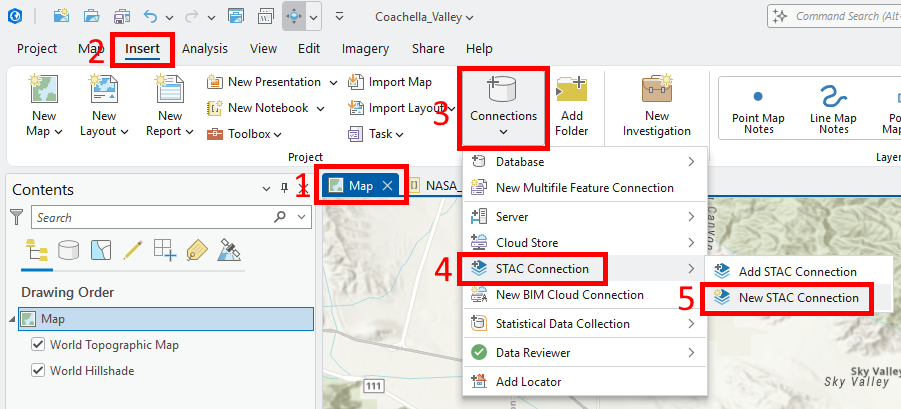
##### For Connection Name use "NASA_Earthdata_LPCLOUD"
##### For Connection use "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
##### Expand the Cloud Storage Connections settings.
##### Click the Add button to choose the ACS File(s) you created using separate notebook. NOTE: for large-scale work use the Amazon type ACS connection files and run this notebook on a virtual machine in AWS region us-west-2 (Oregon).
##### Click the OK button to save your STAC Connection file.
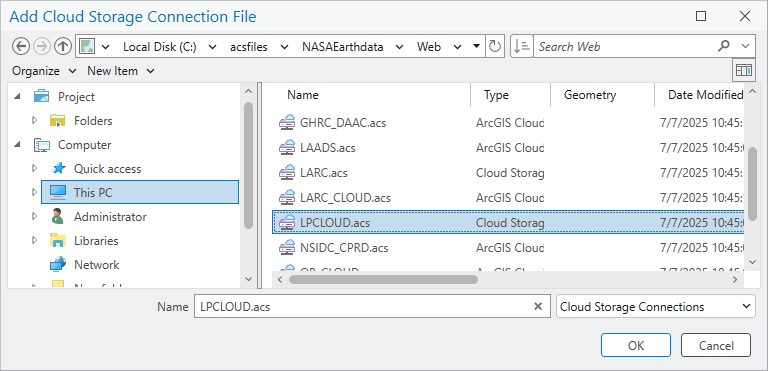
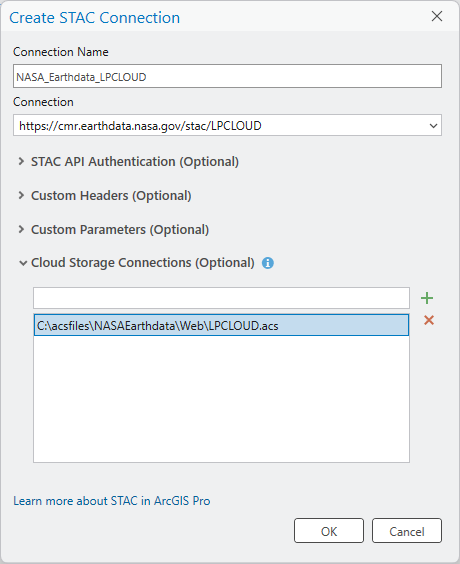
##### Copy the path to your new STAC Connection file. It is saved in the ArcGIS Project folder with the Connection Name you provided.
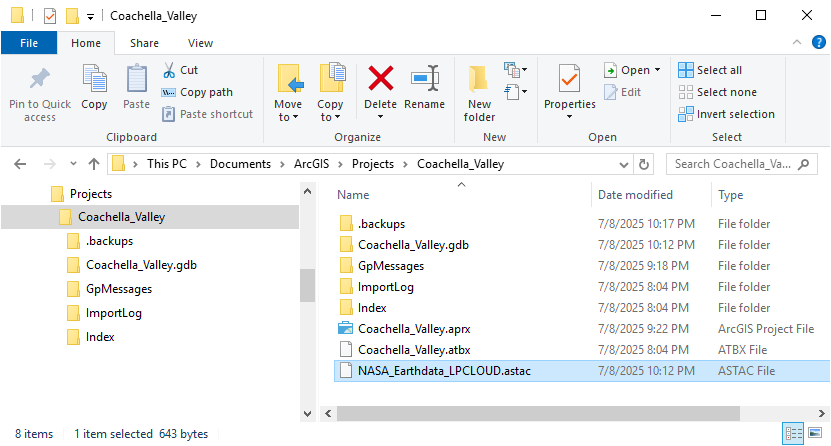

#### Now enter the path to your new ArcGIS STAC Connection File.

In [ ]:
astac_path = input("Enter the full path to your .astac file: ")
astac_path = strip_wrapping_quotes(astac_path)
astac_path += "\StacItemHref/"

#### Set some values for the HLS Landsat collection and run the search to create a CSV item list. NOTE the earliest time available in archive for data is:
#### 2013-01-01T00:00:00Z

In [ ]:
%%time

fq_hlsl_csv_path = input("Enter the full path for HLS Landsat CSV item list output: e.g. c:\path\\to\HLSL_CSV_Items.csv")
fq_hlsl_csv_path = strip_wrapping_quotes(fq_hlsl_csv_path)

time_range = input("enter the time range for query e.g. 2013-01-01T00:00:00Z/2025-06-30T00:00:00Z")
bounding_box = bbox
collection_name = ["HLSL30_2.0"]

hls_stac_query_to_csv_streaming(collection_name, time_range, bounding_box, astac_path, fq_hlsl_csv_path)

#### Set some values for the HLS Sentinel-2 collection and run the search to create a CSV item list

In [ ]:
%%time

fq_hlss_csv_path = input("Enter the full path for HLS Sentinel-2 CSV item list output: e.g. c:\path\\to\HLSS_CSV_Items.csv")
fq_hlss_csv_path = strip_wrapping_quotes(fq_hlss_csv_path)

# Note we're using the same time range and bbox as in the previous HLS query
collection_name = ["HLSS30_2.0"]

hls_stac_query_to_csv_streaming(collection_name, time_range, bounding_box, astac_path, fq_hlss_csv_path)

### Mosaic Dataset Management

#### Create  File Geodatabase

In [ ]:
import arcpy
import os

gdb_folder_path = input("Enter the folder path to use for File Geodatabase: ")
gdb_folder_path = strip_wrapping_quotes(gdb_folder_path)
gdb_name = input("Enter the name for File Geodatabase: e.g. HLS.gdb")
gdb_name = strip_wrapping_quotes(gdb_name)
if not gdb_name.lower().endswith(".gdb"):
    gdb_name += ".gdb"

fqgdb_path = os.path.join(gdb_folder_path, gdb_name)

if not arcpy.Exists(fqgdb_path):
    arcpy.management.CreateFileGDB(gdb_folder_path, gdb_name)
    print("Created FGDB" + fqgdb_path)
else:
    print(f"Skipping create FGDB. {fqgdb_path} Already exists")

#### Create an HLS Mosaic Dataset

In [ ]:
md_name = input("enter the name to use for this Mosaic Dataset: e.g. HLS")

fqmd_path = os.path.join(fqgdb_path, md_name)

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_Auxiliary_Sphere"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],PARAMETER["Standard_Parallel_1",0.0],PARAMETER["Auxiliary_Sphere_Type",0.0],UNIT["Meter",1.0]]'):
    arcpy.management.CreateMosaicDataset(
        in_workspace=fqgdb_path,
        in_mosaicdataset_name=md_name,
        coordinate_system='PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_Auxiliary_Sphere"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],PARAMETER["Standard_Parallel_1",0.0],PARAMETER["Auxiliary_Sphere_Type",0.0],UNIT["Meter",1.0]]',
        num_bands=9,
        pixel_type="",
        product_definition="CUSTOM",
        product_band_definitions="'Coastal Aerosol' 430 450;Blue 450 510;Green 530 590;Red 640 670;'NIR Narrow' 850 880;'SWIR 1' 1570 1650;'SWIR 2' 2110 2290;Cirrus 1360 1380;Fmask # #"
    )

#### Function to Add Rasters from the HLS STAC CSV files

In [ ]:
def add_rasters_from_csv(mdpath, rastertypepath, rasterscsv):
    try:
        with arcpy.EnvManager(parallelProcessingFactor="100%"):
            arcpy.management.AddRastersToMosaicDataset(
                in_mosaic_dataset=mdpath,
                raster_type=rastertypepath,
                input_path=rasterscsv,
                update_cellsize_ranges="UPDATE_CELL_SIZES",
                update_boundary="UPDATE_BOUNDARY",
                update_overviews="NO_OVERVIEWS",
                maximum_pyramid_levels=None,
                maximum_cell_size=0,
                minimum_dimension=1500,
                spatial_reference=None,
                filter="",
                sub_folder="SUBFOLDERS",
                duplicate_items_action="ALLOW_DUPLICATES",
                build_pyramids="NO_PYRAMIDS",
                calculate_statistics="NO_STATISTICS",
                build_thumbnails="NO_THUMBNAILS",
                operation_description="",
                force_spatial_reference="NO_FORCE_SPATIAL_REFERENCE",
                estimate_statistics="NO_STATISTICS",
                aux_inputs=None,
                enable_pixel_cache="NO_PIXEL_CACHE",
                cache_location=""
            )
        return True
    except:
        return False

#### Add the HLS Landsat raster items to Mosaic Dataset

In [ ]:
%%time

# We use a unique Raster Type for these HLS Landsat items
lhsl_raster_type_path = input("Enter full path to HLS Landsat Raster Type: e.g. C:\\projects\\github\\arcgis-nasa-earthdata\\Parameter\\Rastertype\\NASA Earthdata LPCLOUD HLS Landsat.art.xml")
lhsl_raster_type_path = strip_wrapping_quotes(lhsl_raster_type_path)

if add_rasters_from_csv(fqmd_path, lhsl_raster_type_path, fq_hlsl_csv_path):
    print("HLS Landsat rasters added to Mosaic Dataset {}".format(md_name))
else:
    print("Failed adding HLS Landsat rasters to Mosaic Dataset {}".format(md_name))

print(arcpy.GetMessages())

#### Add the HLS Sentinel-2 items to Mosaic Dataset

In [ ]:
%%time

# We use a unique Raster Type for these HLS Sentinel-2 items
hlss_raster_type_path = input("Enter full path to HLS Sentinel-2 Raster Type: e.g. C:\\projects\\github\\arcgis-nasa-earthdata\\Parameter\\Rastertype\\NASA Earthdata LPCLOUD HLS Sentinel2.art.xml")
hlss_raster_type_path = strip_wrapping_quotes(hlss_raster_type_path)

if add_rasters_from_csv(fqmd_path, hlss_raster_type_path, fq_hlss_csv_path):
    print("HLS Sentinel-2 rasters added to Mosaic Dataset {}".format(md_name))
else:
    print("Failed adding HLS Sentinel-2 rasters to Mosaic Dataset {}".format(md_name))
    
print(arcpy.GetMessages())

### Add the DayDate field to Mosaic Dataset

In [ ]:
field_name = "DayDate"
field_type = "DATE"

# Create a mosaic layer
arcpy.MakeMosaicLayer_management(fqmd_path, md_name)

# Reference the Footprint sublayer
footprint_layer = f"{md_name}\\Footprint"

# Check if the field already exists
existing_fields = [f.name for f in arcpy.ListFields(footprint_layer)]
if field_name not in existing_fields:
    arcpy.AddField_management(
        in_table=footprint_layer,
        field_name=field_name,
        field_type=field_type
    )
    print(f"Field '{field_name}' added to Footprint.")
else:
    print(f"Field '{field_name}' already exists.")

### Calculate Values from Acquisition Date

In [ ]:
arcpy.management.CalculateField(
    in_table = f"{md_name}\\Footprint",
    field="DayDate",
    expression="(!AcquisitionDate!).strftime('%m/%d/%Y')",
    expression_type="PYTHON3",
    code_block="",
    field_type="",
    enforce_domains="NO_ENFORCE_DOMAINS"
)

### Add the set of Raster Function Templates that provide on-the-fly composites and indices with and without cloud masking.

In [ ]:
rasterfunctiontemplatepath = input("Enter the folder path containing your HLS raster function set e.g. C:\projects\github\\arcgis-nasa-earthdata\Parameter\RasterFunctionTemplates")
rasterfunctiontemplatepath = strip_wrapping_quotes(rasterfunctiontemplatepath)

arcpy.env.workspace = rasterfunctiontemplatepath
rft_file_paths = []
for rft_file in arcpy.ListFiles("*.xml"):
    rft_file_paths.append(os.path.join(rasterfunctiontemplatepath, rft_file))
rft_file_paths.append("None")
if "Natural Color.rft.xml" in arcpy.ListFiles("*.xml"):
    default_template = os.path.join(rasterfunctiontemplatepath, "Natural Color.rft.xml")
else: 
    default_template = "None"

rft_file_paths =';'.join(rft_file_paths)

# Adds the raster functions to the Mosaic Dataset and set some default properties
arcpy.SetMosaicDatasetProperties_management(
    in_mosaic_dataset = fqmd_path, 
                        processing_templates=rft_file_paths,
                        default_processing_template=default_template,
                        allowed_compressions="None;JPEG;LZ77;LERC",
                        default_compression_type="LERC",
                        JPEG_quality=75,
                        LERC_Tolerance=0.01,
                        default_mosaic_method="ByAttribute",
                        order_field="DayDate",
                        order_base="2050/01/01",
                        use_time="ENABLED",
                        start_time_field="DayDate",
                        end_time_field="",
                        time_format="YYYY/MM/DD")

### Finished. 
#### This Mosaic dataset can be used for on-the-fly analysis with RFTs along with time controls in ArcGIS Pro, or to publish an image service with these same capabilities in a web user experience.

### Optional: 
#### Build Multidimensional Info if you want to conduct multitemporal analysis including change detection or trend analysis tools to identify patterns across multiple dates.

In [ ]:
arcpy.management.BuildMultidimensionalInfo(
    in_mosaic_dataset=fqmd_path,
    variable_field="Tag",
    dimension_fields="DayDate # #",
    variable_desc_units="Dataset # #",
    delete_multidimensional_info="NO_DELETE_MULTIDIMENSIONAL_INFO"
)